<a href="https://colab.research.google.com/github/AmirJlr/Graph-Neural-Networks/blob/master/05-karate-club/karate_club_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [31]:
import torch
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [32]:
### helper functions for VISUALIZATION ###

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="viridis")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="viridis")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [33]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [34]:
dataset[0]

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [35]:


data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [36]:
data.edge_index.t()

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

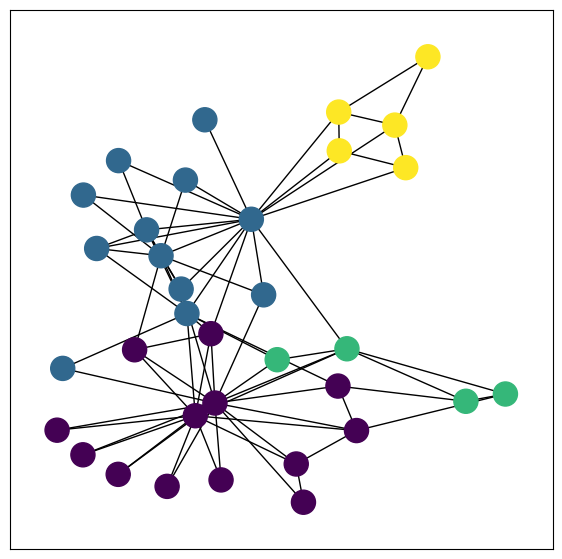

In [37]:
### Graph Visualization ###
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, data.y)

## Implementing Graph Neural Networks

PyG implements GCN layer via `GCNConv`, which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

In [38]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)

        self.gconv1 = GCNConv(dataset.num_features, 6)
        self.gconv2 = GCNConv(6, 4)
        self.gconv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gconv1(x, edge_index)
        h = h.tanh()
        h = self.gconv2(h, edge_index)
        h = h.tanh()
        h = self.gconv3(h, edge_index)
        h = h.tanh() # Final GNN embedding space.

        # Apply classifier
        out = self.classifier(h)
        return out, h

In [39]:
model = GCN()
print(model)

GCN(
  (gconv1): GCNConv(34, 6)
  (gconv2): GCNConv(6, 4)
  (gconv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.

Here, we pass in the initial node features x and the graph connectivity information edge_index to the model, and visualize its 2-dimensional embedding.

In [40]:
model(data.x, data.edge_index) # => return : out, h

(tensor([[-0.1039, -0.6397, -0.4569,  0.5561],
         [-0.1093, -0.6547, -0.4696,  0.5493],
         [-0.1226, -0.6732, -0.4824,  0.5520],
         [-0.1192, -0.6734, -0.4842,  0.5458],
         [-0.1118, -0.6780, -0.4921,  0.5282],
         [-0.1012, -0.6707, -0.4894,  0.5179],
         [-0.1002, -0.6734, -0.4926,  0.5133],
         [-0.1135, -0.6737, -0.4869,  0.5359],
         [-0.1211, -0.6847, -0.4947,  0.5368],
         [-0.1159, -0.6893, -0.5016,  0.5231],
         [-0.1152, -0.6822, -0.4948,  0.5295],
         [-0.0844, -0.6570, -0.4831,  0.5039],
         [-0.1237, -0.6886, -0.4975,  0.5372],
         [-0.1164, -0.6767, -0.4887,  0.5375],
         [-0.1241, -0.6931, -0.5019,  0.5329],
         [-0.1235, -0.7020, -0.5112,  0.5222],
         [-0.0952, -0.6748, -0.4962,  0.5032],
         [-0.1100, -0.6746, -0.4894,  0.5288],
         [-0.1366, -0.7096, -0.5130,  0.5366],
         [-0.1104, -0.6759, -0.4906,  0.5282],
         [-0.1335, -0.7025, -0.5073,  0.5388],
         [-0.

In [41]:
_, h = model(data.x, data.edge_index)
print(type(h))
print(h.shape)

<class 'torch.Tensor'>
torch.Size([34, 2])


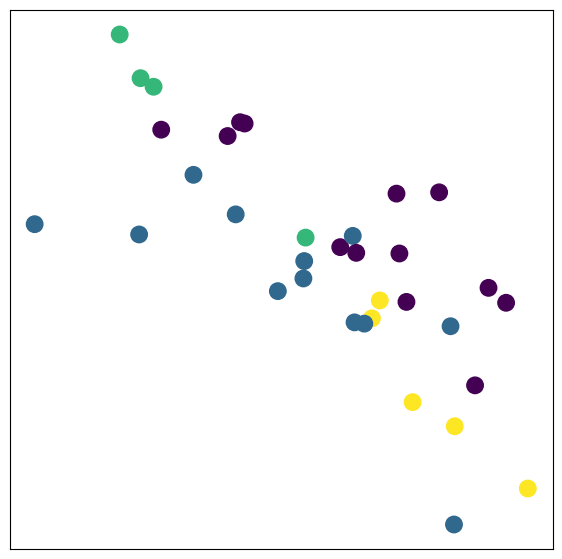

In [42]:
visualize_embedding(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.

 Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized completely at random and we have not yet performed any training so far!

 This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.

Here, this is implemented by filtering the output of the classifier out and ground-truth labels data.y to only contain the nodes in the train_mask.

<IPython.core.display.Javascript object>

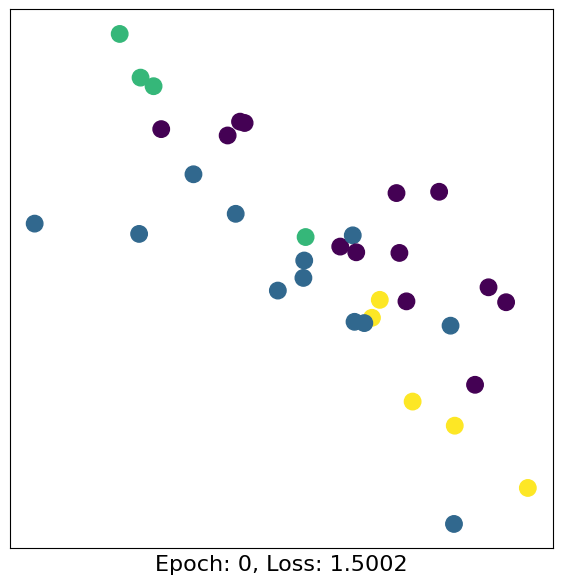

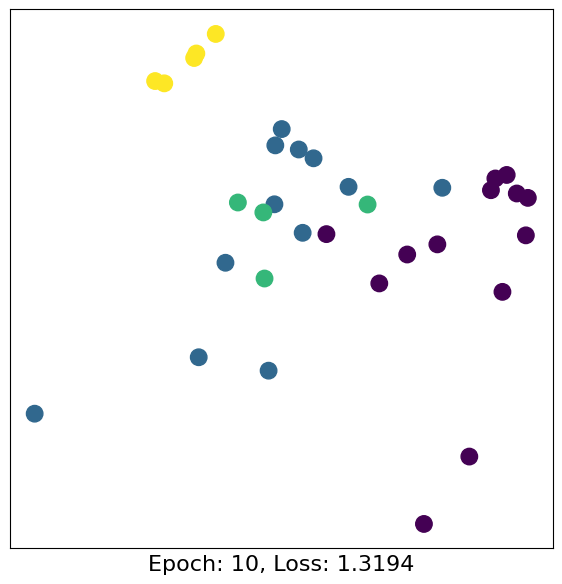

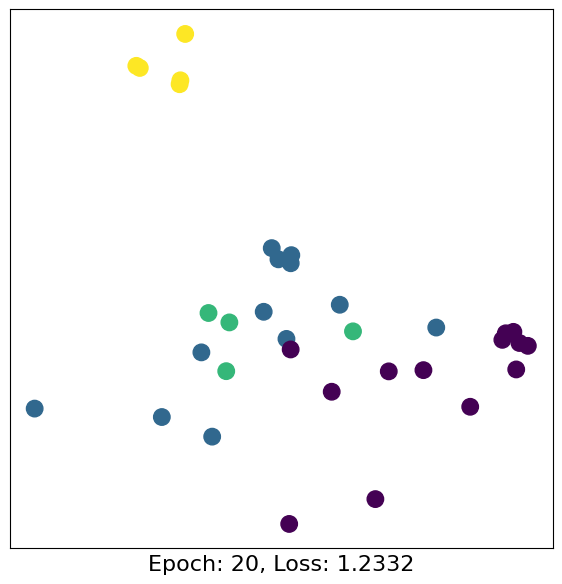

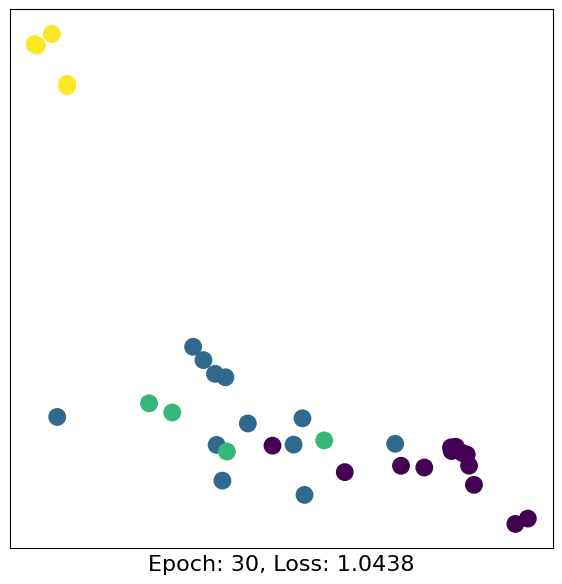

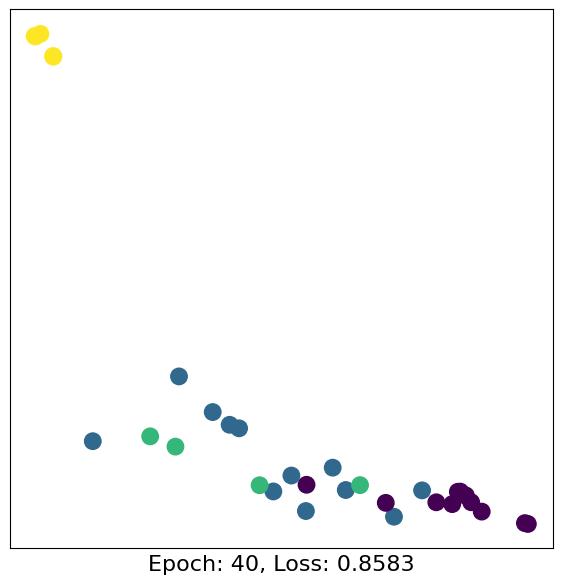

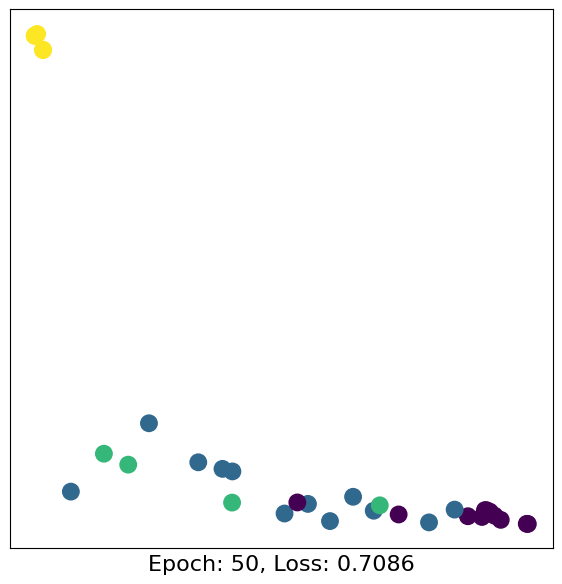

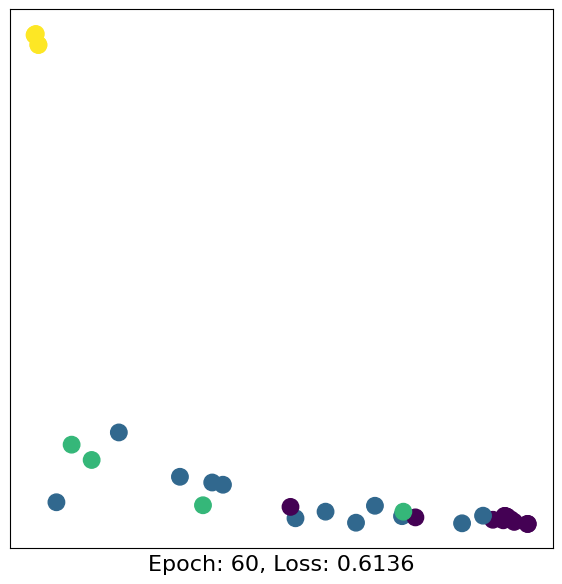

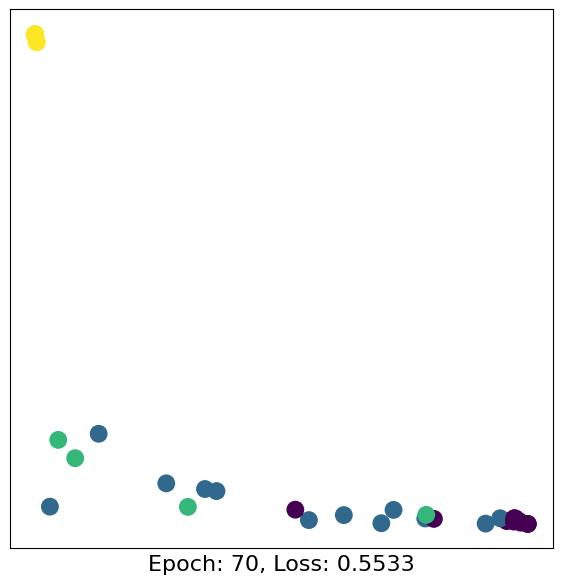

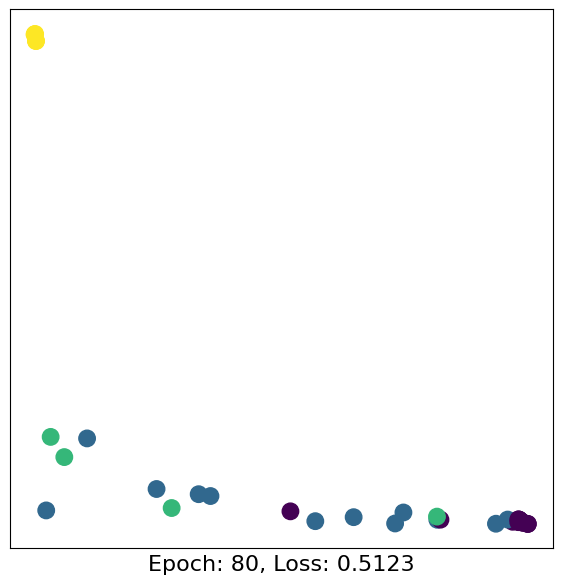

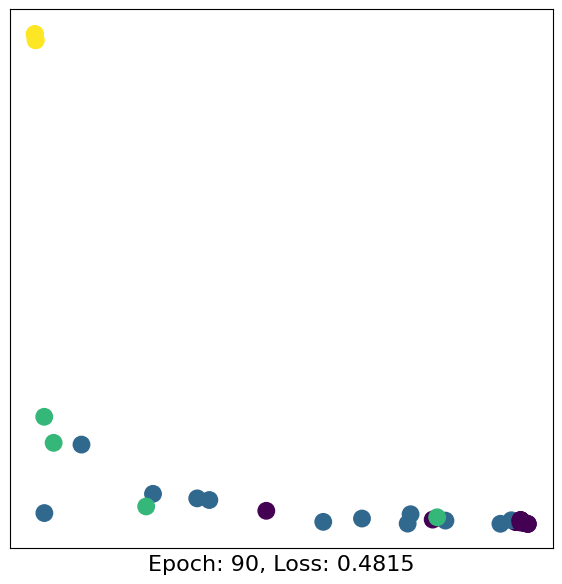

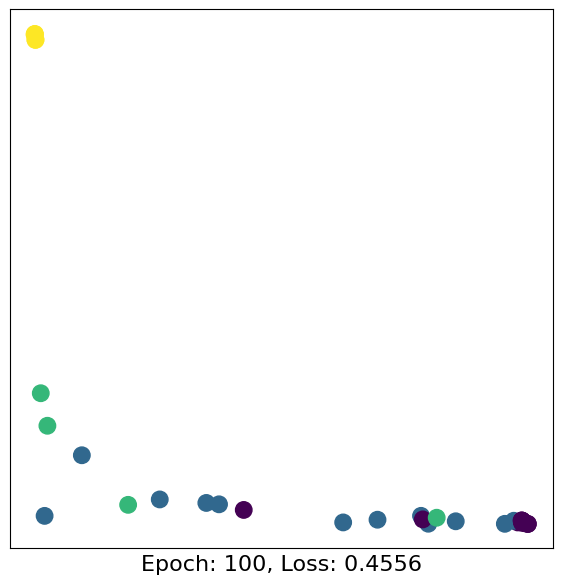

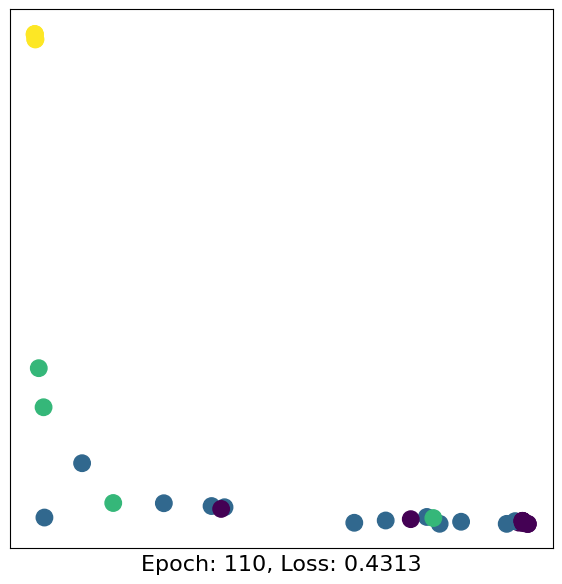

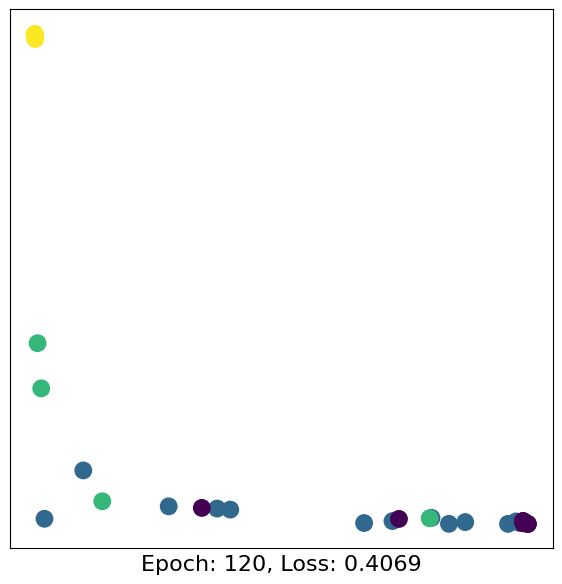

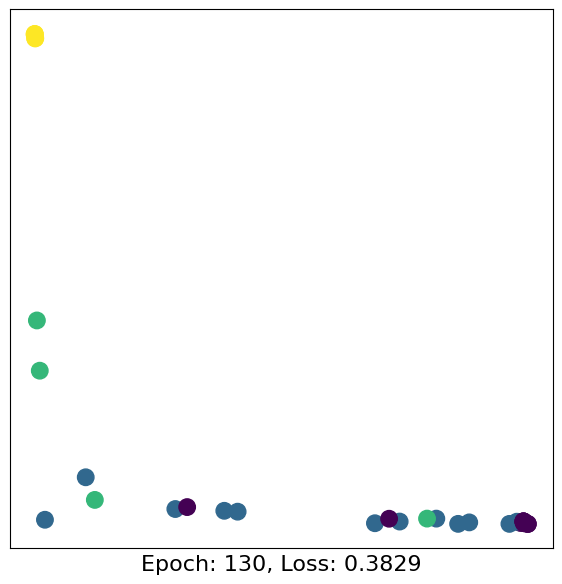

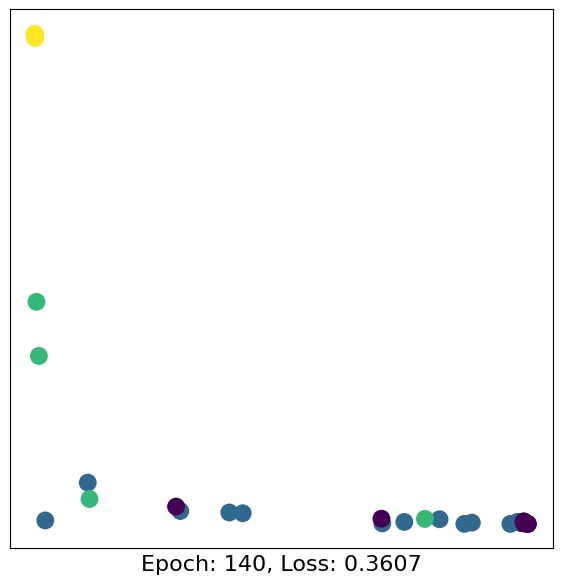

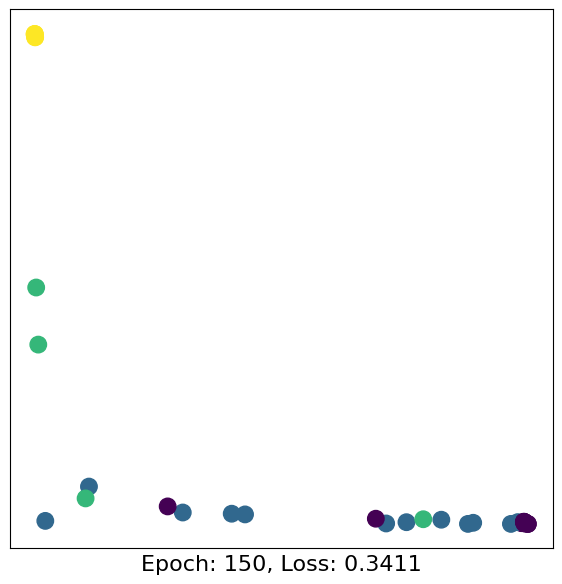

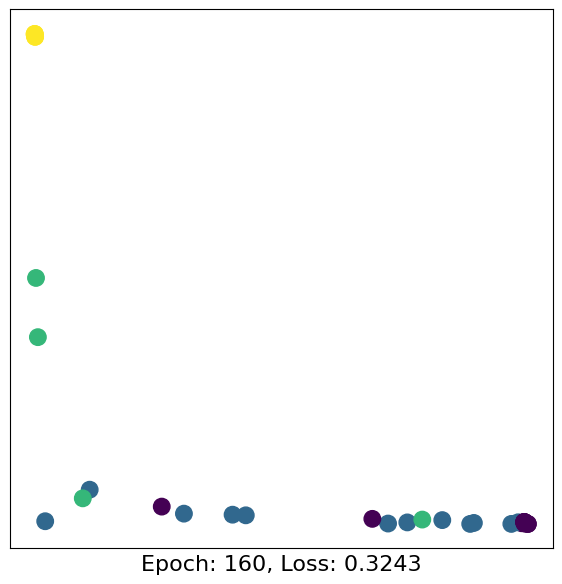

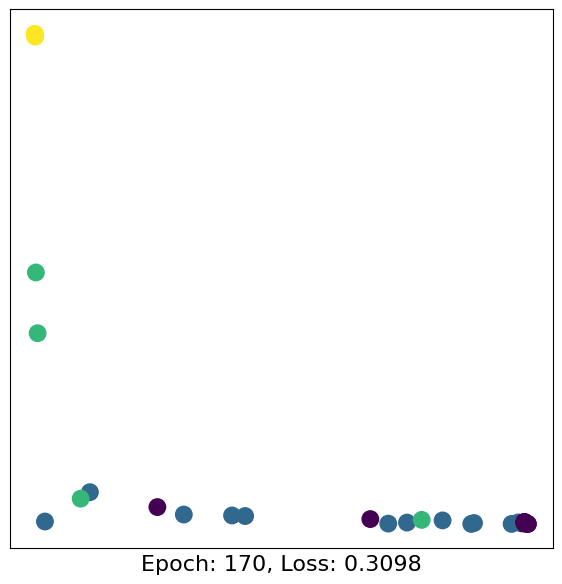

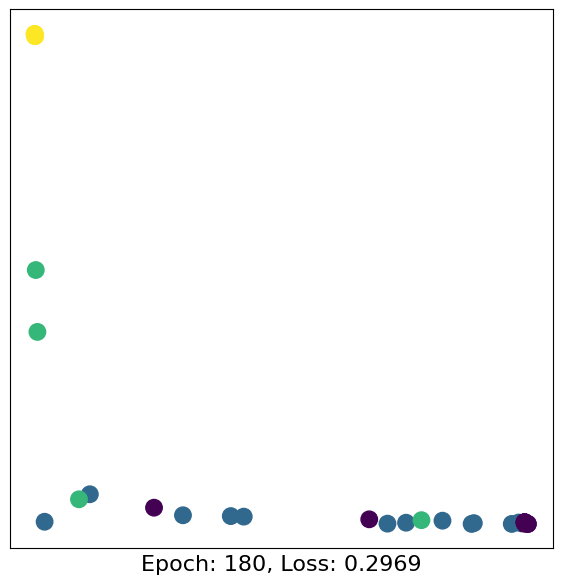

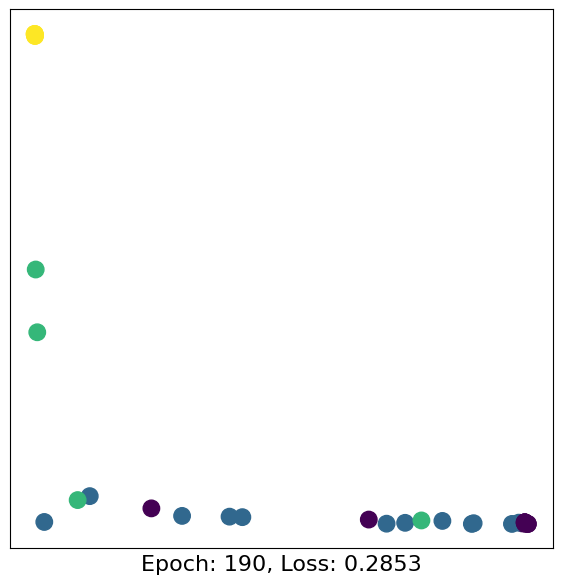

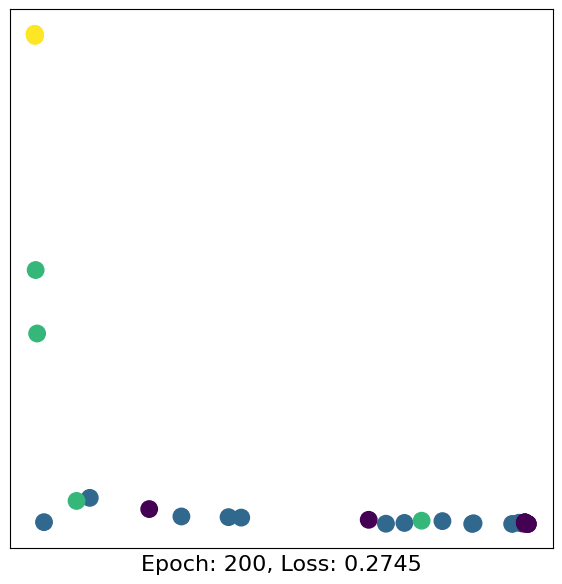

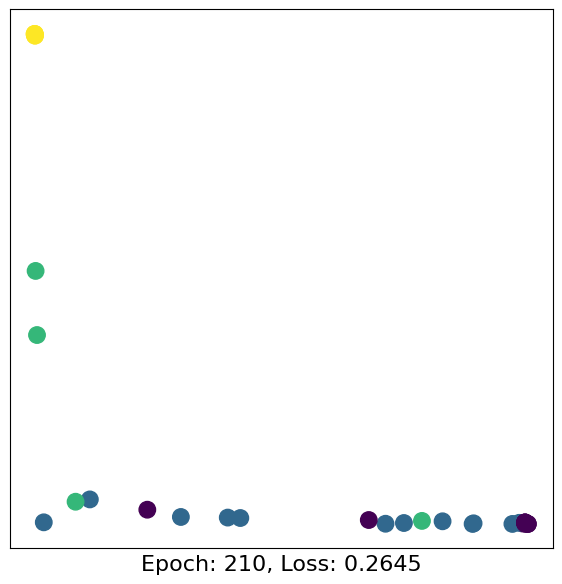

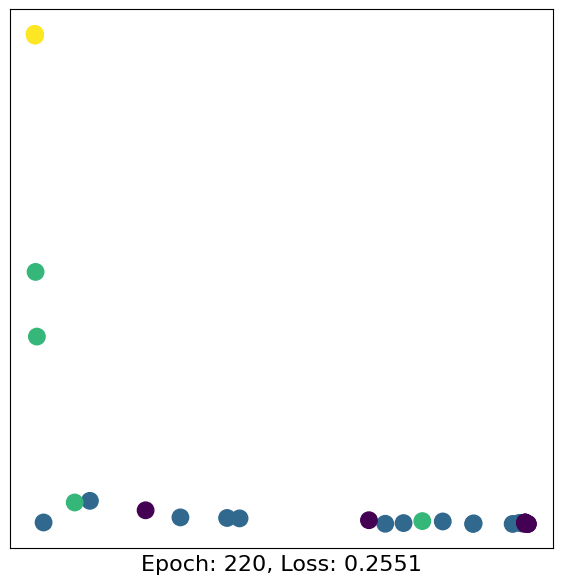

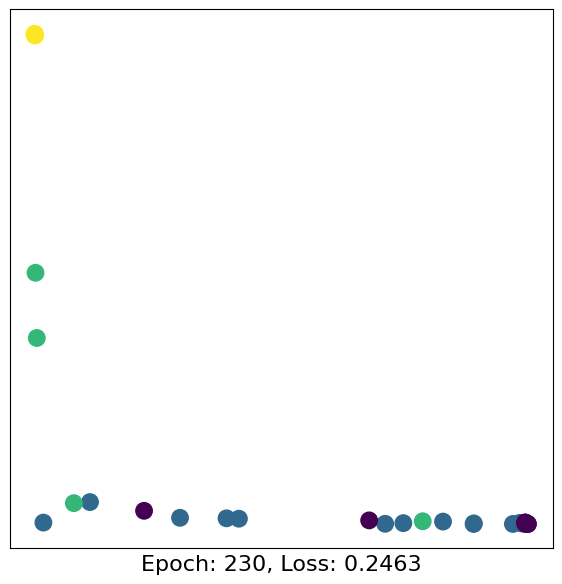

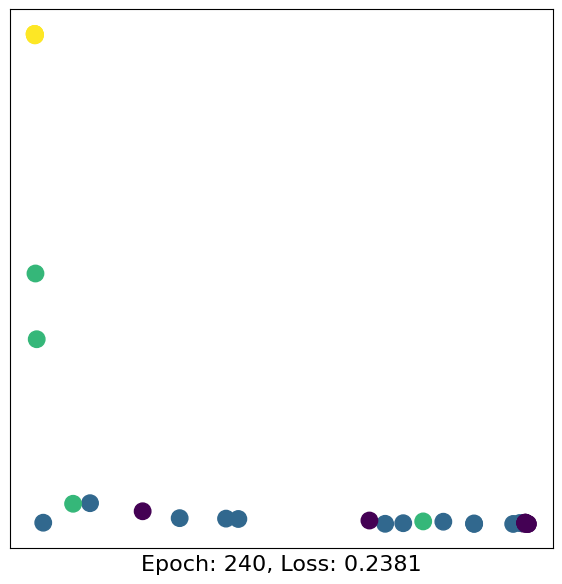

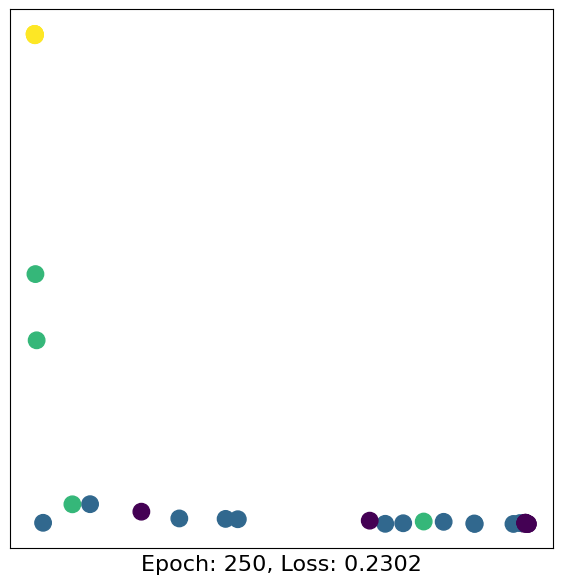

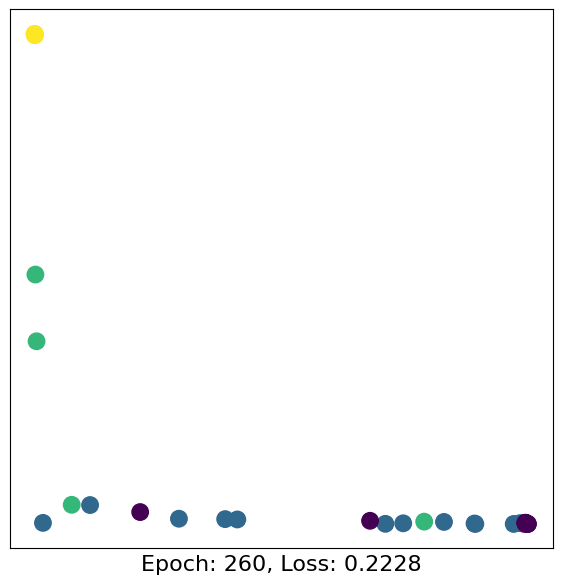

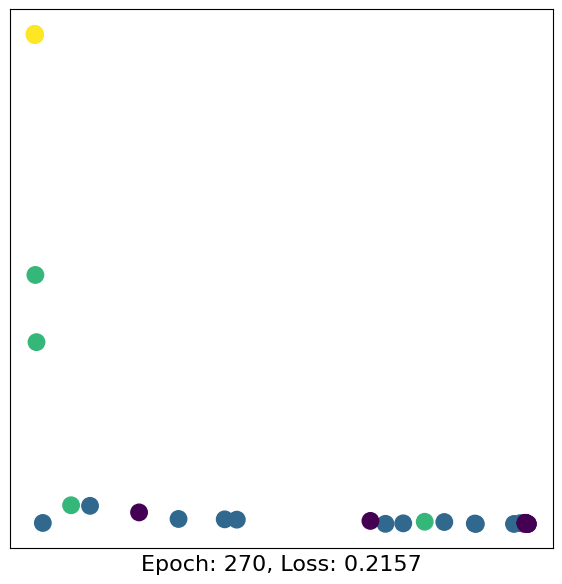

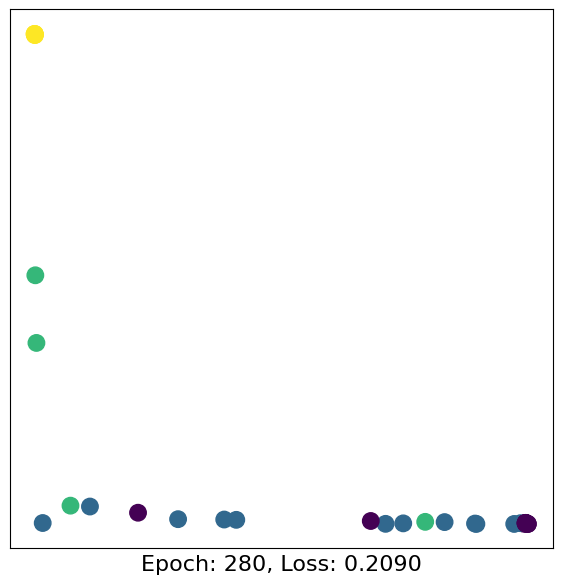

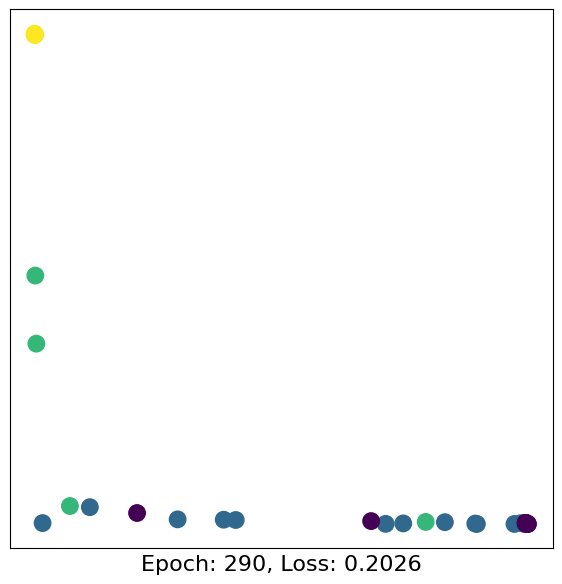

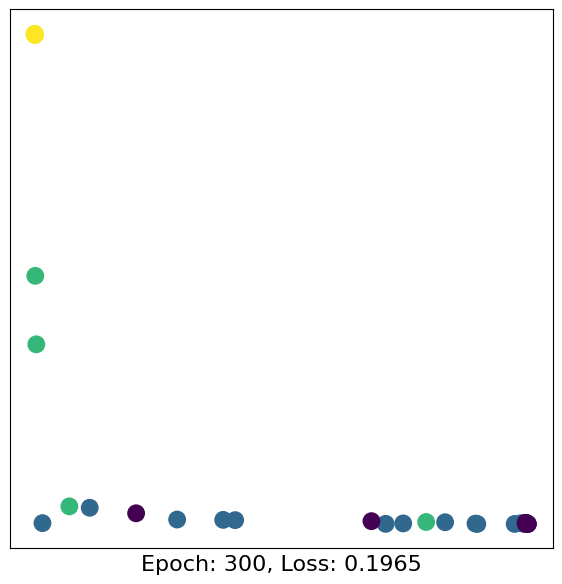

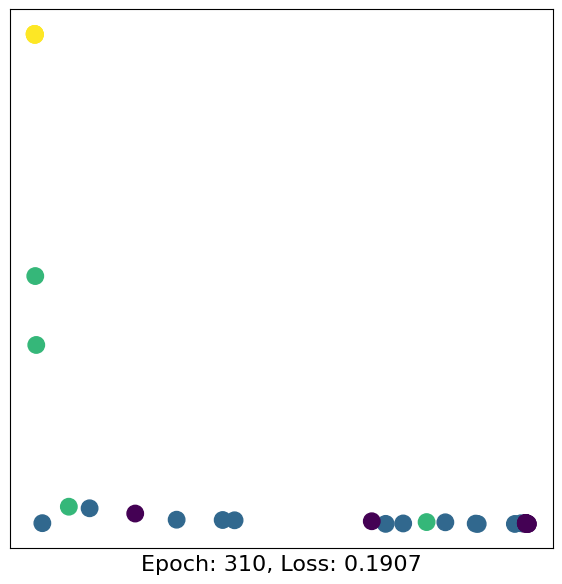

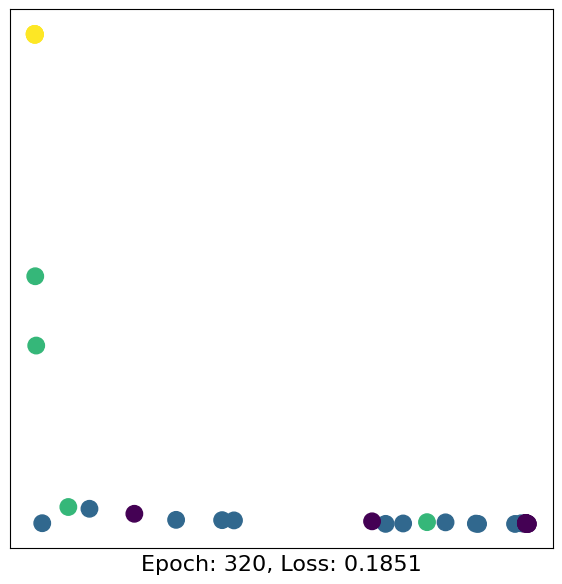

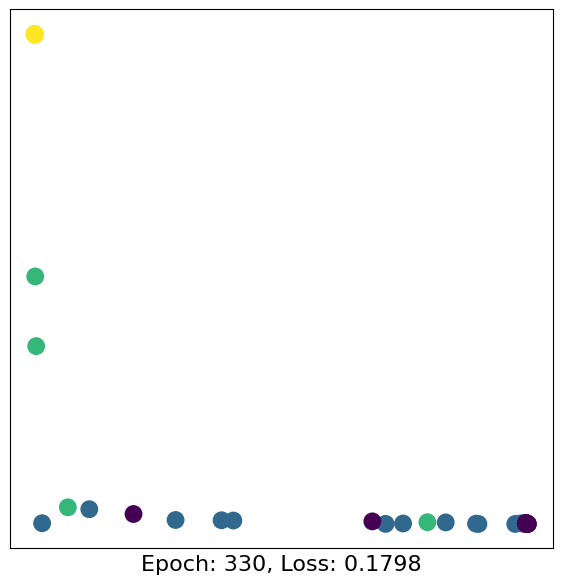

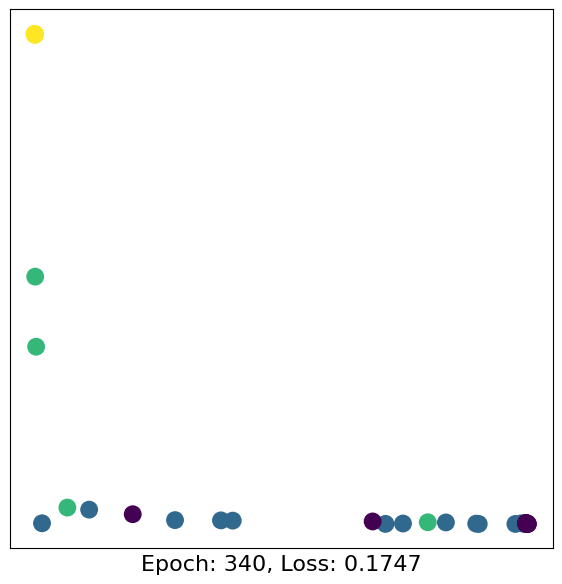

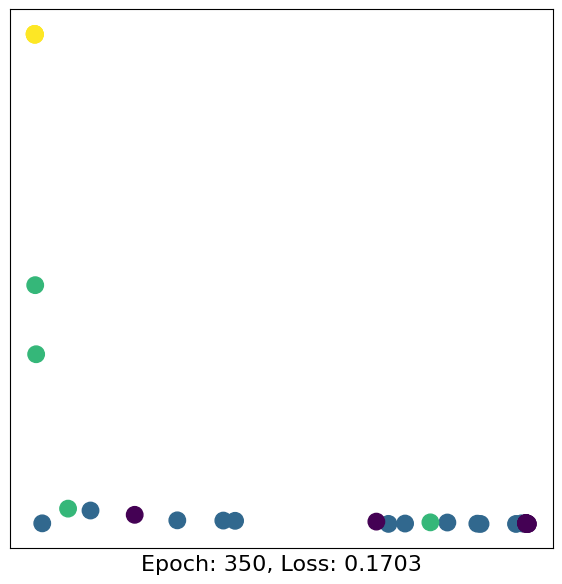

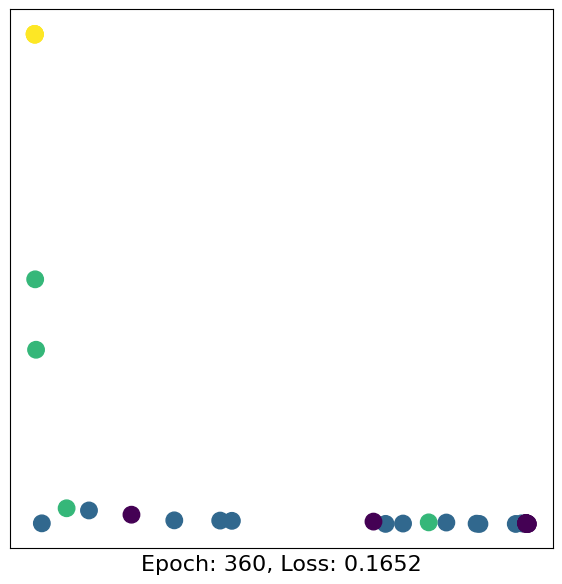

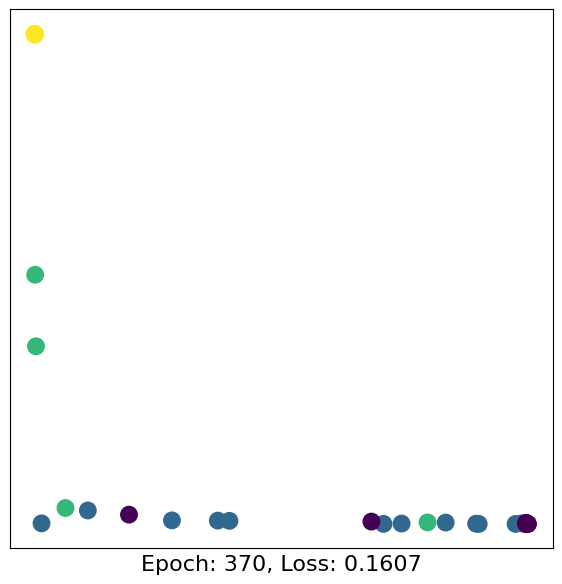

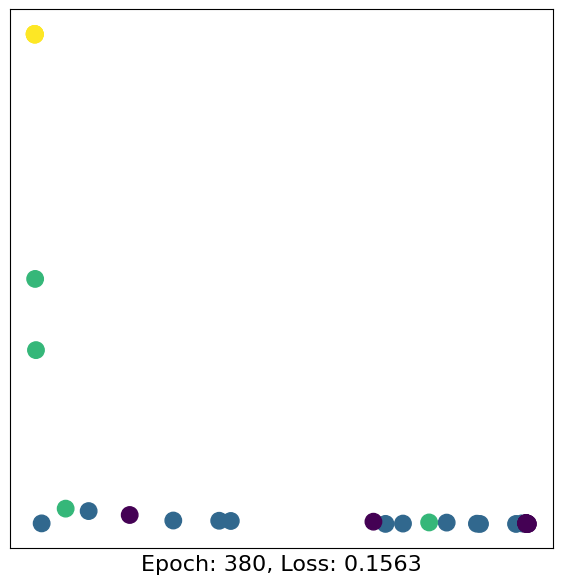

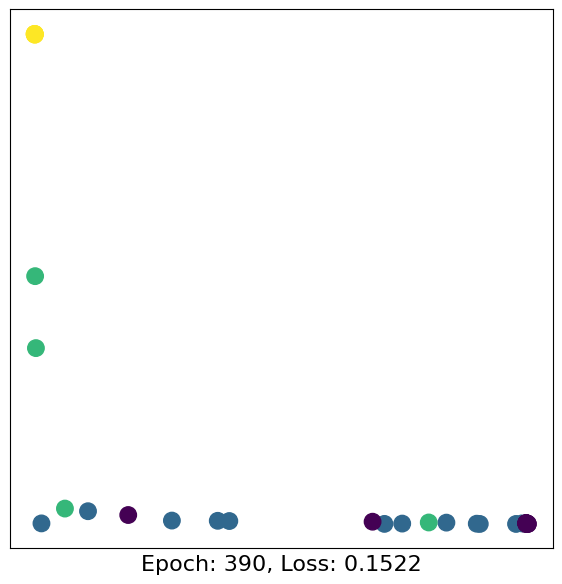

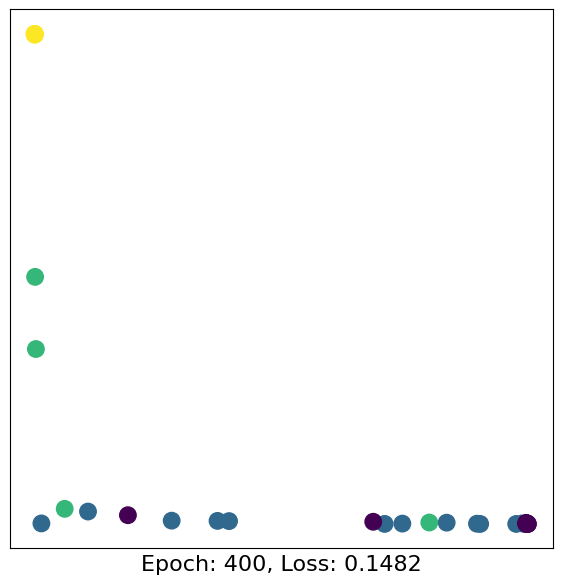

In [44]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)